In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb

In [37]:
df = pd.read_csv('HousingDataset.csv')

In [38]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,6090000,6615,4,2,2,yes,yes,no,yes,no,1,no,semi-furnished
1,5530000,6100,3,2,1,yes,no,yes,no,no,2,yes,furnished
2,3500000,4600,4,1,2,yes,no,no,no,no,0,no,semi-furnished
3,6090000,6600,3,1,1,yes,yes,yes,no,no,2,yes,semi-furnished
4,7962500,6000,3,1,4,yes,yes,no,no,yes,2,no,unfurnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,3675000,3600,2,1,1,yes,no,no,no,no,0,no,furnished
323,4060000,4320,3,1,2,yes,no,no,no,no,2,yes,furnished
324,2275000,1836,2,1,1,no,no,yes,no,no,0,no,semi-furnished
325,5943000,15600,3,1,1,yes,no,no,no,yes,2,no,semi-furnished


In [39]:
X = df.drop(columns=['price']) 
y = df['price']

In [40]:
categorical_features = [i for i in df.columns if df[i].dtype in ["object"]]
numerical_features = [i for i in df.columns if df[i].dtype in ["int","float"]]
for i in categorical_features:
    df[i] = df[i].astype("category")


In [41]:
params={
    "boosting_type":"gbdt",
    "n_estimators":1000,
    "learning_rate":0.1,
    "verbose":1,
    #"metrics":"mse"
}



In [42]:
df_train = df.drop("price",axis=1)
target = df.price
scores = []
models = []

kf = KFold(n_splits=4,shuffle=True,random_state=71)
for tr_idx, va_idx in kf.split(df_train):
    tr_x,va_x = df_train.iloc[tr_idx],df_train.iloc[va_idx]
    tr_y,va_y = target.iloc[tr_idx],target.iloc[va_idx]
    
    model = lgb.LGBMRegressor(**params)
    model.fit(tr_x,tr_y,
             eval_set=[(va_x,va_y)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=100),
                        lgb.callback.log_evaluation(period=100)])
    pred = model.predict(va_x)
    score = np.sqrt(mean_squared_error(pred,va_y))
    scores.append(score)
    models.append(model)
#Check model's roughly score from this.If this is bad, think about preprrocess and FE part. 
print(np.mean(scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 109
[LightGBM] [Info] Number of data points in the train set: 245, number of used features: 12
[LightGBM] [Info] Start training from score 4908857.142857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [43]:
pred_y= model.predict(tr_x)
for x,y in zip(pred_y, tr_y):
    print(x, y, np.abs(x-y))

6698270.150266429 5530000 1168270.1502664294
5306564.71211574 6090000 783435.2878842596
5950174.188309946 7962500 2012325.811690054
4539509.085493316 6160000 1620490.914506684
3476831.1254753848 2730000 746831.1254753848
3232679.426080677 2940000 292679.4260806772
6408187.535452866 5320000 1088187.535452866
4596052.552142141 6650000 2053947.4478578586
5804684.346401215 5950000 145315.6535987854
4673382.123376485 4165000 508382.12337648496
7266205.972447363 6790000 476205.9724473627
5866298.341608265 5460000 406298.3416082654
5223082.083955958 5740000 516917.91604404245
7238796.219879809 7210000 28796.219879808836
3482382.3426050507 3395000 87382.34260505065
7346706.580315545 12250000 4903293.419684455
3920369.1939856377 4900000 979630.8060143623
7895542.019220281 7245000 650542.0192202814
4665006.446877325 6475000 1809993.553122675
4047140.303671372 3885000 162140.30367137212
2772628.1050954266 2870000 97371.89490457345
5760253.575316081 4543000 1217253.5753160808
4799509.616031598 427

In [44]:
tr_y

1      5530000
3      6090000
4      7962500
5      6160000
6      2730000
        ...   
321    5950000
322    3675000
324    2275000
325    5943000
326    4403000
Name: price, Length: 246, dtype: int64

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

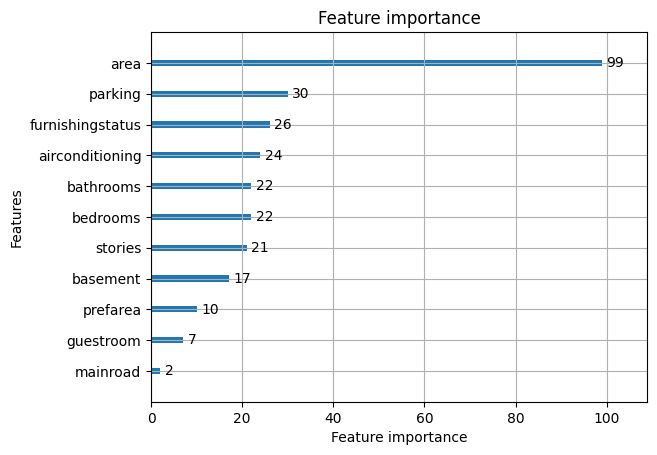

In [45]:
lgb.plot_importance(models[2],max_num_features=35)

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostRegressor

X, y= tr_x, tr_y
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])
clf = AdaBoostRegressor(random_state=0, n_estimators=100)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', clf)
])

model.fit(X, y)

model.score(X, y)

0.4847570677746318

In [47]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingClassifier


In [49]:
df_train = df.drop("price",axis=1)
target = df.price
scores = []
models = []
all_scores=[]
kf = KFold(n_splits=4,shuffle=True,random_state=71)

r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

regs = [AdaBoostRegressor(random_state=0, n_estimators=100),
          BaggingRegressor(estimator=SVR(),n_estimators=10, random_state=0),
          ExtraTreesRegressor(n_estimators=100, random_state=0),
          GradientBoostingRegressor(random_state=0),
          RandomForestRegressor(max_depth=2, random_state=0),
          StackingRegressor(estimators=[ ('lr', RidgeCV()),('svr', LinearSVR(dual="auto", random_state=42))], final_estimator=RandomForestRegressor(n_estimators=10,)),
          VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)]),
          HistGradientBoostingClassifier()]
for reg in regs:
    scores=[]
    for tr_idx, va_idx in kf.split(df_train):
        tr_x,va_x = df_train.iloc[tr_idx],df_train.iloc[va_idx]
        tr_y,va_y = target.iloc[tr_idx],target.iloc[va_idx]

        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])
        preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features)])
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('reg', reg)
        ])
        model.fit(tr_x,tr_y)
        pred = model.predict(va_x)
        score = np.sqrt(mean_squared_error(pred,va_y))
        scores.append(score)
        models.append(model)
#Check model's roughly score from this.If this is bad, think about preprrocess and FE part. 
    print(np.mean(scores))
    all_scores.append(np.mean(scores))

1636133.3060170957
1993254.3287228728
1700959.6434228483
1606071.9811177317
1601244.1791142428
1687156.141308404
1515541.3551513655
1982191.0759120407


In [53]:
len(names)

7

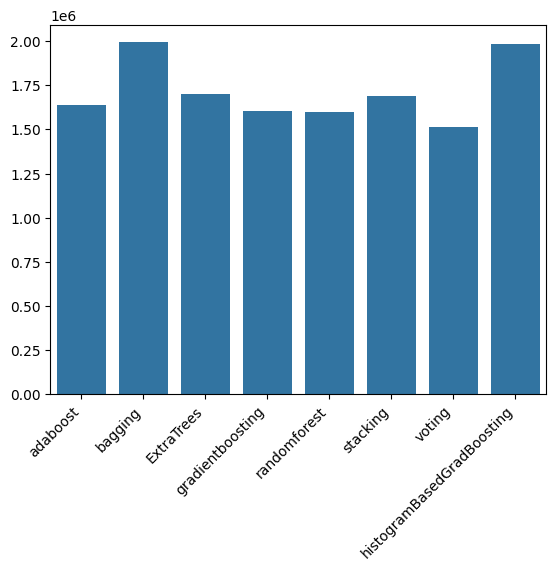

In [55]:
names = ['adaboost','bagging','ExtraTrees','gradientboosting', 'randomforest', 'stacking', 'voting','histogramBasedGradBoosting']
sns.barplot(x=names, y=all_scores)
plt.xticks(rotation=45, ha='right')  # Rotate the labels by 45 degrees and align to the right

# Show the plot
plt.show()


 mu = 15.31 and sigma = 0.38



C:\Users\alavibajestan.1a\AppData\Local\Temp\3\ipykernel_13104\608511599.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['price'] , fit=norm);


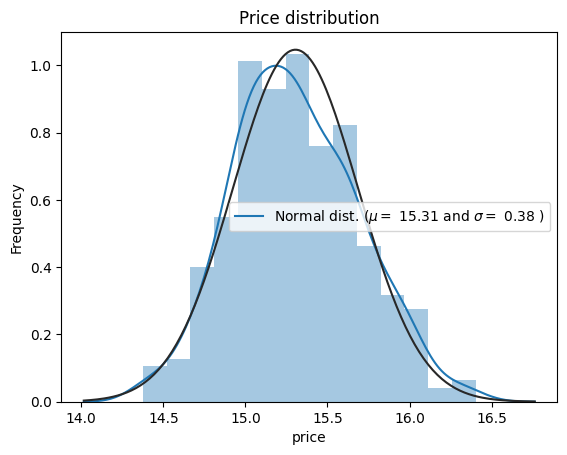

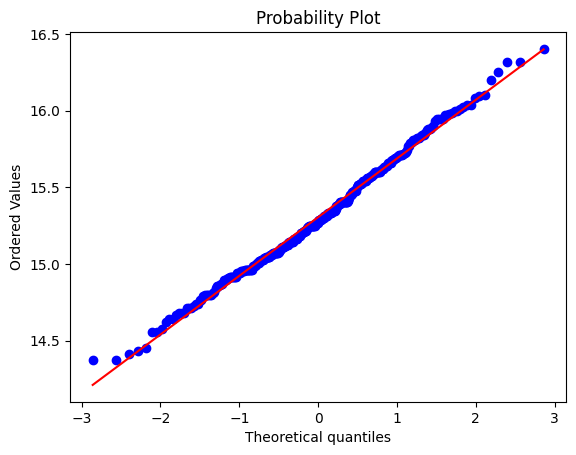

In [57]:
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
import copy

df1 = copy.copy(df)
df1["price"] = np.log1p(df["price"])

#Check the new distribution 
sns.distplot(df1['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df1['price'], plot=plt)
plt.show()

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'area'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'stories'}>,
        <Axes: title={'center': 'parking'}>]], dtype=object)

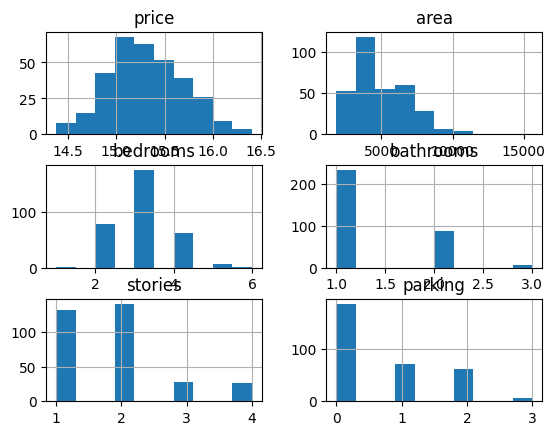

In [59]:
df1.hist()